In [1]:
!pip install koreanize-matplotlib
!pip install category_encoders

# 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 필요한 모듈 import

In [3]:
import pandas as pd  # 데이터 프레임 처리
import numpy as np  # 수치 연산 및 배열 처리
import random  # 랜덤 시드 설정
import os  # 환경 변수 설정
import easydict
import pytz  # 시간대 처리
import math

# 날짜 및 시간 처리
import time
from datetime import datetime
today = datetime.today().strftime('%m%d')

# 머신러닝 관련 라이브러리
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV  # 데이터 분할 및 교차 검증
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score  # 모델 평가 지표
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# 머신러닝 모델 저장
import joblib

# 시각화 관련 라이브러리
import koreanize_matplotlib  # 한글 폰트 적용
import seaborn as sns  # 데이터 시각화
import matplotlib.pyplot as plt

# 랜덤 시드를 고정하여 실험 재현성을 확보하는 함수
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


# Global Variables

In [4]:
args = easydict.EasyDict()

# path info
args.default_path = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/miniproj_2nd/"
args.file_path = args.default_path + 'miniproj_data/Cluster_3_Filtered.csv'
args.model_path = args.default_path + 'model/'
args.model_comparison_path = args.default_path + 'model_comparison/'

# 기타 설정
args.random_seed = 42

# 추후의 확인을 위한 리스트
args.results = []

# 여러 모델들을 실험하게 될텐데 최종 결과를 보고 헷갈리지 않도록 설정
args.model_name = ''

# 한국 타임존 설정
kst = pytz.timezone('Asia/Seoul')


<hr>

# Load Data

In [5]:
data = pd.read_csv(args.file_path)

# 데이터 확인
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Loyalty_Score
0,47,15602280,Martin,829,Germany,Female,27,9,112045.67,1,1,1,119708.21,1,1,3,DIAMOND,779,34.29
1,48,15771573,Okagbue,637,Germany,Female,39,9,137843.80,1,1,1,117622.80,1,1,1,SILVER,730,27.80
2,52,15768193,Trevisani,585,Germany,Male,36,5,146050.97,2,0,0,86424.57,0,0,3,SILVER,665,27.15
3,61,15651280,Hunter,742,Germany,Male,35,5,136857.00,1,0,0,84509.57,0,0,4,GOLD,823,29.73
4,62,15773469,Clark,687,Germany,Female,27,9,152328.88,2,0,0,126494.82,0,0,5,DIAMOND,769,40.19


## 메타데이터
- **RowNumber**
  - 설명: 각 행의 고유 일련 번호
  - 데이터 타입: int64 (또는 numeric)
  - 예시 값: `2501`

- **CustomerId**
  - 설명: 고객을 식별하기 위한 고유 번호
  - 데이터 타입: object
  - 예시 값: `15715694.40`

- **Surname**
  - 설명: 고객의 성
  - 데이터 타입: object
  - 예시 값: `Smith`

- **CreditScore**
  - 설명: 고객의 신용 점수
  - 데이터 타입: int64
  - 예시 값: `651`

- **Geography**
  - 설명: 고객의 국가 (예: France, Spain, Germany)
  - 데이터 타입: object
  - 예시 값: `France`

- **Gender**
  - 설명: 고객의 성별 (Male / Female)
  - 데이터 타입: object
  - 예시 값: `Male`

- **Age**
  - 설명: 고객의 나이
  - 데이터 타입: int64
  - 예시 값: `39`

- **Tenure**
  - 설명: 신용 카드 사용 기간 (년 단위)
  - 데이터 타입: int64
  - 예시 값: `5`

- **Balance**
  - 설명: 신용 카드 잔액
  - 데이터 타입: float64
  - 예시 값: `76500`

- **NumOfProducts**
  - 설명: 고객이 사용하는 제품 수
  - 데이터 타입: int64
  - 예시 값: `2`

- **HasCrCard**
  - 설명: 고객이 신용 카드를 보유하고 있는지 여부 (0: 없음, 1: 있음)
  - 데이터 타입: int64
  - 예시 값: `1`

- **IsActiveMember**
  - 설명: 고객이 활동적인 회원인지 여부
  - 데이터 타입: int64
  - 예시 값: `1`

- **EstimatedSalary**
  - 설명: 고객의 예상 연봉
  - 데이터 타입: float64
  - 예시 값: `100000`

- **Exited**
  - 설명: 고객의 이탈 여부 (0: 미이탈, 1: 이탈)
  - 데이터 타입: int64
  - 예시 값: `0`

- **Complain**
  - 설명: 고객 불만 여부 (0: 불만 없음, 1: 불만 있음)
  - 데이터 타입: int64
  - 예시 값: `0`

- **Satisfaction Score**
  - 설명: 불만 해결에 대한 고객 만족도 (1 ~ 5)
  - 데이터 타입: float64
  - 예시 값: `3`

- **Card Type**
  - 설명: 신용 카드 종류
  - 데이터 타입: object
  - 예시 값: `DIAMOND`

- **Point Earned**
  - 설명: 고객이 적립한 포인트
  - 데이터 타입: int64 (또는 float64)
  - 예시 값: `607`

# model_rf_V0
- OneHot 인코딩 적용

In [6]:
data.columns, len(data.columns)

(Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
        'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
        'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score'],
       dtype='object'),
 19)

## Train & Test Split

In [7]:
reset_seeds()

df = data.copy()

target_col = 'Exited'

train, test = train_test_split(df, test_size=0.3, stratify=df[target_col], random_state=args.random_seed)

train.shape, test.shape

((781, 19), (335, 19))

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 358 to 1008
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           781 non-null    int64  
 1   CustomerId          781 non-null    int64  
 2   Surname             781 non-null    object 
 3   CreditScore         781 non-null    int64  
 4   Geography           781 non-null    object 
 5   Gender              781 non-null    object 
 6   Age                 781 non-null    int64  
 7   Tenure              781 non-null    int64  
 8   Balance             781 non-null    float64
 9   NumOfProducts       781 non-null    int64  
 10  HasCrCard           781 non-null    int64  
 11  IsActiveMember      781 non-null    int64  
 12  EstimatedSalary     781 non-null    float64
 13  Exited              781 non-null    int64  
 14  Complain            781 non-null    int64  
 15  Satisfaction Score  781 non-null    int64  
 16  Card Type 

## Encoding & Scaling

In [9]:
# 제외할 특성들
del_list = ['Surname', 'RowNumber', 'Complain', 'CustomerId']

# 특성과 타겟 변수 분리
X_train = train.drop(columns=[target_col] + del_list)
y_train = train[target_col]
X_test = test.drop(columns=[target_col] + del_list)
y_test = test[target_col]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((781, 14), (335, 14), (781,), (335,))

In [10]:
X_train.columns, X_test.columns, y_train.name, y_test.name

(Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score'],
       dtype='object'),
 Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score'],
       dtype='object'),
 'Exited',
 'Exited')

In [11]:
# 전체 열 출력 설정
pd.options.display.max_columns = None

# 상위 5개 샘플 출력
display(X_train.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Loyalty_Score
358,637,Germany,Female,36,10,145750.45,2,1,1,96660.76,1,DIAMOND,407,28.07
617,638,France,Male,34,6,114543.27,1,1,1,97755.29,4,DIAMOND,613,31.13
975,807,Germany,Male,37,10,130110.45,2,0,1,172097.95,4,DIAMOND,539,38.39
785,574,France,Male,33,8,100267.03,1,1,0,103006.27,2,DIAMOND,949,29.49
139,719,France,Male,32,9,146605.27,1,1,1,77119.45,2,GOLD,603,29.53


In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 358 to 1008
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         781 non-null    int64  
 1   Geography           781 non-null    object 
 2   Gender              781 non-null    object 
 3   Age                 781 non-null    int64  
 4   Tenure              781 non-null    int64  
 5   Balance             781 non-null    float64
 6   NumOfProducts       781 non-null    int64  
 7   HasCrCard           781 non-null    int64  
 8   IsActiveMember      781 non-null    int64  
 9   EstimatedSalary     781 non-null    float64
 10  Satisfaction Score  781 non-null    int64  
 11  Card Type           781 non-null    object 
 12  Point Earned        781 non-null    int64  
 13  Loyalty_Score       781 non-null    float64
dtypes: float64(3), int64(8), object(3)
memory usage: 91.5+ KB


In [13]:
reset_seeds()

print(f"before | Train 데이터 NaN 개수: {X_train.isnull().sum().sum()}, Test 데이터 NaN 개수: {X_test.isnull().sum().sum()}")
print(f"before | Train : {X_train.shape}, Test : {X_test.shape}")

onehot_col = ["Geography", "Gender", "Card Type"]

# OneHotEncoder 정의 (args.onehot_col을 기반으로 적용)
encoder = OneHotEncoder(cols=onehot_col, handle_unknown='ignore', use_cat_names=True)

# 원-핫 인코딩 적용
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# 결과 출력
print(f"\nafter | Train 데이터 NaN 개수: {X_train.isnull().sum().sum()}, Test 데이터 NaN 개수: {X_test.isnull().sum().sum()}")
print(f"after | Train : {X_train.shape}, Test : {X_test.shape}")

before | Train 데이터 NaN 개수: 0, Test 데이터 NaN 개수: 0
before | Train : (781, 14), Test : (335, 14)

after | Train 데이터 NaN 개수: 0, Test 데이터 NaN 개수: 0
after | Train : (781, 20), Test : (335, 20)


## Training

In [14]:
reset_seeds()

model_name = "model_rf_V0"

parameters = {
    'random_state' : args.random_seed,
}

# RandomForest 기본 모델 적용
model_rf_V0 = RandomForestClassifier(**parameters, n_jobs=-1)
model_rf_V0.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [15]:
reset_seeds()

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=args.random_seed)

cv_accuracy = cross_val_score(model_rf_V0, X_train, y_train, cv=kf, scoring='accuracy')
cv_roc_auc = cross_val_score(model_rf_V0, X_train, y_train, cv=kf, scoring='roc_auc')
cv_f1 = cross_val_score(model_rf_V0, X_train, y_train, cv=kf, scoring='f1')

# 교차검증 평균 성능 출력
print("========================================")
print(f"Mean Accuracy: {cv_accuracy.mean()}")
print(f"Mean ROC-AUC Score: {cv_roc_auc.mean()}")
print(f"Mean F1 Score: {cv_f1.mean()}")

Mean Accuracy: 0.8783511846802986
Mean ROC-AUC Score: 0.7056782229800133
Mean F1 Score: 0.10909090909090909


## Evaluation

### 테스트셋 평가

In [16]:
reset_seeds()

y_test_pred = model_rf_V0.predict(X_test)
y_test_pred_proba = model_rf_V0.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

# 테스트셋 성능 출력
print("========================================")
print(f"Test Accuracy: {test_acc}")
print(f"Test ROC-AUC Score: {test_roc_auc}")
print(f"Test F1 Score: {test_f1}")

Test Accuracy: 0.8895522388059701
Test ROC-AUC Score: 0.6912233195285122
Test F1 Score: 0.24489795918367346


### 결과 정리

In [17]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'tr_cv_mean_acc': cv_accuracy.mean(),
        'tr_cv_mean_roc_auc': cv_roc_auc.mean(),
        'tr_cv_mean_f1': cv_f1.mean(),
        'test_acc': test_acc,
        'test_roc_auc' : test_roc_auc,
        'test_f1' : test_f1,
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [18]:
# 일반화 성능이 가장 좋은 모델을 선택하는 기준 적용
df_results = pd.DataFrame(args.results).assign(
    f1_diff=lambda df: abs(df['tr_cv_mean_f1'] - df['test_f1'])  # 교차검증(Train f1) - Test f1 차이 계산
).sort_values(by=['f1_diff', 'test_f1'], ascending=[True, False])  # f1 차이가 낮은 순서 → 테스트 f1 높은 순서 정렬

df_results


,model,parameters,tr_cv_mean_acc,tr_cv_mean_roc_auc,tr_cv_mean_f1,test_acc,test_roc_auc,test_f1,create_dt,f1_diff
0,model_rf_V0,{'random_state': 42},0.878351,0.705678,0.109091,0.889552,0.691223,0.244898,2025-03-04 17:16:48,0.135807


## Save Model

In [19]:
# 모델 저장 디렉터리가 존재하지 않으면 생성
os.makedirs(args.model_path, exist_ok=True)

# 모델 저장 경로 설정
model_save_path = os.path.join(args.model_path, "cluster3_model_rf_V0.pkl")

# 기존 파일이 존재하더라도 덮어쓰기 수행
joblib.dump(model_rf_V0, model_save_path)

print(f"✅ 모델이 저장되었습니다: {model_save_path}")

✅ 모델이 저장되었습니다: /content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/miniproj_2nd/model/cluster3_model_rf_V0.pkl


## Load Model

In [20]:
# import lightgbm as lgb

# 모델 파일 경로 지정 (저장된 파일명과 일치해야 함)
model_load_path = os.path.join(args.model_path, "cluster3_model_rf_V0.pkl")

# RandomForest 모델 불러오기
loaded_model = joblib.load(model_load_path)

print("✅ 불러온 RandomForest 모델이 정상적으로 로드되었습니다.")

✅ 불러온 RandomForest 모델이 정상적으로 로드되었습니다.


## 불러온 모델 테스트

In [21]:
reset_seeds()

# 테스트 데이터로 예측 수행
y_test_pred_proba = loaded_model.predict(X_test)  # 확률 값 반환
y_test_pred = (y_test_pred_proba > 0.5).astype(int)  # 0.5 기준 이진 분류

# 평가 지표 계산
test_acc = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

# 테스트셋 성능 출력
print("========================================")
print(f"✅ Test F1 Score: {test_f1}")


✅ Test F1 Score: 0.24489795918367346


# model_rf_V1
- OneHot 인코딩 적용
- SMOTE 적용

In [22]:
data.columns, len(data.columns)

(Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
        'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
        'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score'],
       dtype='object'),
 19)

## Train & Test Split

In [23]:
reset_seeds()

df = data.copy()

target_col = 'Exited'

train, test = train_test_split(df, test_size=0.3, stratify=df[target_col], random_state=args.random_seed)

train.shape, test.shape

((781, 19), (335, 19))

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 358 to 1008
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           781 non-null    int64  
 1   CustomerId          781 non-null    int64  
 2   Surname             781 non-null    object 
 3   CreditScore         781 non-null    int64  
 4   Geography           781 non-null    object 
 5   Gender              781 non-null    object 
 6   Age                 781 non-null    int64  
 7   Tenure              781 non-null    int64  
 8   Balance             781 non-null    float64
 9   NumOfProducts       781 non-null    int64  
 10  HasCrCard           781 non-null    int64  
 11  IsActiveMember      781 non-null    int64  
 12  EstimatedSalary     781 non-null    float64
 13  Exited              781 non-null    int64  
 14  Complain            781 non-null    int64  
 15  Satisfaction Score  781 non-null    int64  
 16  Card Type 

## Encoding & Scaling

In [25]:
# 제외할 특성들
del_list = ['Surname', 'RowNumber', 'Complain', 'CustomerId']

# 특성과 타겟 변수 분리
X_train = train.drop(columns=[target_col] + del_list)
y_train = train[target_col]
X_test = test.drop(columns=[target_col] + del_list)
y_test = test[target_col]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((781, 14), (335, 14), (781,), (335,))

In [26]:
X_train.columns, X_test.columns, y_train.name, y_test.name

(Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score'],
       dtype='object'),
 Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score'],
       dtype='object'),
 'Exited',
 'Exited')

In [27]:
# 전체 열 출력 설정
pd.options.display.max_columns = None

# 상위 5개 샘플 출력
display(X_train.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Loyalty_Score
358,637,Germany,Female,36,10,145750.45,2,1,1,96660.76,1,DIAMOND,407,28.07
617,638,France,Male,34,6,114543.27,1,1,1,97755.29,4,DIAMOND,613,31.13
975,807,Germany,Male,37,10,130110.45,2,0,1,172097.95,4,DIAMOND,539,38.39
785,574,France,Male,33,8,100267.03,1,1,0,103006.27,2,DIAMOND,949,29.49
139,719,France,Male,32,9,146605.27,1,1,1,77119.45,2,GOLD,603,29.53


In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 358 to 1008
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         781 non-null    int64  
 1   Geography           781 non-null    object 
 2   Gender              781 non-null    object 
 3   Age                 781 non-null    int64  
 4   Tenure              781 non-null    int64  
 5   Balance             781 non-null    float64
 6   NumOfProducts       781 non-null    int64  
 7   HasCrCard           781 non-null    int64  
 8   IsActiveMember      781 non-null    int64  
 9   EstimatedSalary     781 non-null    float64
 10  Satisfaction Score  781 non-null    int64  
 11  Card Type           781 non-null    object 
 12  Point Earned        781 non-null    int64  
 13  Loyalty_Score       781 non-null    float64
dtypes: float64(3), int64(8), object(3)
memory usage: 91.5+ KB


In [29]:
reset_seeds()

print(f"before | Train 데이터 NaN 개수: {X_train.isnull().sum().sum()}, Test 데이터 NaN 개수: {X_test.isnull().sum().sum()}")
print(f"before | Train : {X_train.shape}, Test : {X_test.shape}")

onehot_col = ["Geography", "Gender", "Card Type"]

# OneHotEncoder 정의 (args.onehot_col을 기반으로 적용)
encoder = OneHotEncoder(cols=onehot_col, handle_unknown='ignore', use_cat_names=True)

# 원-핫 인코딩 적용
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# 결과 출력
print(f"\nafter | Train 데이터 NaN 개수: {X_train.isnull().sum().sum()}, Test 데이터 NaN 개수: {X_test.isnull().sum().sum()}")
print(f"after | Train : {X_train.shape}, Test : {X_test.shape}")

before | Train 데이터 NaN 개수: 0, Test 데이터 NaN 개수: 0
before | Train : (781, 14), Test : (335, 14)

after | Train 데이터 NaN 개수: 0, Test 데이터 NaN 개수: 0
after | Train : (781, 20), Test : (335, 20)


## SMOTE

In [30]:
reset_seeds()

# SMOTE 적용
# smote = SMOTE(sampling_strategy=1.0, random_state=args.random_seed)
smote = SMOTE(random_state=args.random_seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {X_train.shape}, {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {X_train_resampled.shape}, {y_train_resampled.value_counts().to_dict()}")

Before SMOTE: (781, 20), {0: 682, 1: 99}
After SMOTE: (1364, 20), {0: 682, 1: 682}


## Training

In [31]:
reset_seeds()

model_name = "model_rf_V1"

parameters = {
    'random_state' : args.random_seed,
}

# RandomForest 기본 모델 적용
model_rf_V1 = RandomForestClassifier(**parameters, n_jobs=-1)
model_rf_V1.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [32]:
reset_seeds()

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=args.random_seed)

cv_accuracy = cross_val_score(model_rf_V1, X_train_resampled, y_train_resampled, cv=kf, scoring='accuracy')
cv_roc_auc = cross_val_score(model_rf_V1, X_train_resampled, y_train_resampled, cv=kf, scoring='roc_auc')
cv_f1 = cross_val_score(model_rf_V1, X_train_resampled, y_train_resampled, cv=kf, scoring='f1')

# 교차검증 평균 성능 출력
print("========================================")
print(f"Mean Accuracy: {cv_accuracy.mean()}")
print(f"Mean ROC-AUC Score: {cv_roc_auc.mean()}")
print(f"Mean F1 Score: {cv_f1.mean()}")

Mean Accuracy: 0.9252415199656505
Mean ROC-AUC Score: 0.9759814891429717
Mean F1 Score: 0.9226263443042984


## Evaluation

### 테스트셋 평가

In [33]:
reset_seeds()

y_test_pred = model_rf_V1.predict(X_test)
y_test_pred_proba = model_rf_V1.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

# 테스트셋 성능 출력
print("========================================")
print(f"Test Accuracy: {test_acc}")
print(f"Test ROC-AUC Score: {test_roc_auc}")
print(f"Test F1 Score: {test_f1}")

Test Accuracy: 0.8507462686567164
Test ROC-AUC Score: 0.6696400127429117
Test F1 Score: 0.07407407407407407


### 결과 정리

In [34]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'tr_cv_mean_acc': cv_accuracy.mean(),
        'tr_cv_mean_roc_auc': cv_roc_auc.mean(),
        'tr_cv_mean_f1': cv_f1.mean(),
        'test_acc': test_acc,
        'test_roc_auc' : test_roc_auc,
        'test_f1' : test_f1,
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [35]:
# 일반화 성능이 가장 좋은 모델을 선택하는 기준 적용
df_results = pd.DataFrame(args.results).assign(
    f1_diff=lambda df: abs(df['tr_cv_mean_f1'] - df['test_f1'])  # 교차검증(Train f1) - Test f1 차이 계산
).sort_values(by=['f1_diff', 'test_f1'], ascending=[True, False])  # f1 차이가 낮은 순서 → 테스트 f1 높은 순서 정렬

df_results


,model,parameters,tr_cv_mean_acc,tr_cv_mean_roc_auc,tr_cv_mean_f1,test_acc,test_roc_auc,test_f1,create_dt,f1_diff
0,model_rf_V0,{'random_state': 42},0.878351,0.705678,0.109091,0.889552,0.691223,0.244898,2025-03-04 17:16:48,0.135807
1,model_rf_V1,{'random_state': 42},0.925242,0.975981,0.922626,0.850746,0.669640,0.074074,2025-03-04 17:17:04,0.848552


## Save Model

In [36]:
# 모델 저장 디렉터리가 존재하지 않으면 생성
os.makedirs(args.model_path, exist_ok=True)

# 모델 저장 경로 설정
model_save_path = os.path.join(args.model_path, "cluster3_model_rf_V1.pkl")

# 기존 파일이 존재하더라도 덮어쓰기 수행
joblib.dump(model_rf_V1, model_save_path)

print(f"✅ 모델이 저장되었습니다: {model_save_path}")

✅ 모델이 저장되었습니다: /content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/miniproj_2nd/model/cluster3_model_rf_V1.pkl


## Load Model

In [37]:
# import lightgbm as lgb

# 모델 파일 경로 지정 (저장된 파일명과 일치해야 함)
model_load_path = os.path.join(args.model_path, "cluster3_model_rf_V1.pkl")

# RandomForest 모델 불러오기
loaded_model = joblib.load(model_load_path)

print("✅ 불러온 RandomForest 모델이 정상적으로 로드되었습니다.")

✅ 불러온 RandomForest 모델이 정상적으로 로드되었습니다.


## 불러온 모델 테스트

In [38]:
reset_seeds()

# 테스트 데이터로 예측 수행
y_test_pred_proba = loaded_model.predict(X_test)  # 확률 값 반환
y_test_pred = (y_test_pred_proba > 0.5).astype(int)  # 0.5 기준 이진 분류

# 평가 지표 계산
test_acc = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

# 테스트셋 성능 출력
print("========================================")
print(f"✅ Test F1 Score: {test_f1}")


✅ Test F1 Score: 0.07407407407407407


# model_rf_V2
- OneHot 인코딩 적용
- SMOTE 적용
- 새로운 특성 추가

In [39]:
data.columns, len(data.columns)

(Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
        'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
        'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score'],
       dtype='object'),
 19)

## Train & Test Split

In [40]:
reset_seeds()

df = data.copy()

target_col = 'Exited'

train, test = train_test_split(df, test_size=0.3, stratify=df[target_col], random_state=args.random_seed)

train.shape, test.shape

((781, 19), (335, 19))

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 358 to 1008
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           781 non-null    int64  
 1   CustomerId          781 non-null    int64  
 2   Surname             781 non-null    object 
 3   CreditScore         781 non-null    int64  
 4   Geography           781 non-null    object 
 5   Gender              781 non-null    object 
 6   Age                 781 non-null    int64  
 7   Tenure              781 non-null    int64  
 8   Balance             781 non-null    float64
 9   NumOfProducts       781 non-null    int64  
 10  HasCrCard           781 non-null    int64  
 11  IsActiveMember      781 non-null    int64  
 12  EstimatedSalary     781 non-null    float64
 13  Exited              781 non-null    int64  
 14  Complain            781 non-null    int64  
 15  Satisfaction Score  781 non-null    int64  
 16  Card Type 

## Feature Extraction

In [42]:
reset_seeds()

def add_complain_score(dataframe):
    dataframe['z_Age'] = (dataframe['Age'] - dataframe['Age'].mean()) / dataframe['Age'].std()
    dataframe['z_EstimatedSalary'] = (dataframe['EstimatedSalary'] - dataframe['EstimatedSalary'].mean()) / dataframe['EstimatedSalary'].std()
    dataframe['z_Balance'] = (dataframe['Balance'] - dataframe['Balance'].mean()) / dataframe['Balance'].std()
    dataframe['z_Loyalty_Score'] = (dataframe['Loyalty_Score'] - dataframe['Loyalty_Score'].mean()) / dataframe['Loyalty_Score'].std()
    corr = dataframe[['Age', 'EstimatedSalary', 'Balance', 'Loyalty_Score', 'Complain']].corr()
    # 상관관계 기반 가중치 (절대값 합으로 정규화한 값)
    w_age = corr['Complain']['Age'] / corr['Complain'].abs().sum()-1
    w_est = corr['Complain']['EstimatedSalary'] / corr['Complain'].abs().sum()-1
    w_bal = corr['Complain']['Balance'] / corr['Complain'].abs().sum()-1
    w_lcs = corr['Complain']['Loyalty_Score'] / corr['Complain'].abs().sum()-1

    # 새로운 피처 생성: Complain 값이 1인 경우 가중합을, 0인 경우 0이 되도록 함.
    dataframe['Complain_score'] = (5e-5 + dataframe['Complain']) * (
        w_age * dataframe['z_Age'] + w_est * dataframe['z_EstimatedSalary'] + w_bal * dataframe['z_Balance'] + w_lcs * dataframe['z_Loyalty_Score']
    )
    dataframe.drop(['z_Age', 'z_EstimatedSalary', 'z_Balance', 'z_Loyalty_Score'], axis=1, inplace=True)

# 학습 데이터 및 테스트 데이터에 새로운 피처 추가
add_complain_score(train)
add_complain_score(test)

## Encoding & Scaling

In [43]:
# 제외할 특성들
del_list = ['Surname', 'RowNumber', 'Complain', 'CustomerId']

# 특성과 타겟 변수 분리
X_train = train.drop(columns=[target_col] + del_list)
y_train = train[target_col]
X_test = test.drop(columns=[target_col] + del_list)
y_test = test[target_col]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((781, 15), (335, 15), (781,), (335,))

In [44]:
X_train.columns, X_test.columns, y_train.name, y_test.name

(Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score',
        'Complain_score'],
       dtype='object'),
 Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score',
        'Complain_score'],
       dtype='object'),
 'Exited',
 'Exited')

In [45]:
# 전체 열 출력 설정
pd.options.display.max_columns = None

# 상위 5개 샘플 출력
display(X_train.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Loyalty_Score,Complain_score
358,637,Germany,Female,36,10,145750.45,2,1,1,96660.76,1,DIAMOND,407,28.07,0.000028
617,638,France,Male,34,6,114543.27,1,1,1,97755.29,4,DIAMOND,613,31.13,0.000069
975,807,Germany,Male,37,10,130110.45,2,0,1,172097.95,4,DIAMOND,539,38.39,-0.000178
785,574,France,Male,33,8,100267.03,1,1,0,103006.27,2,DIAMOND,949,29.49,0.000120
139,719,France,Male,32,9,146605.27,1,1,1,77119.45,2,GOLD,603,29.53,0.000069


In [46]:
reset_seeds()

print(f"before | Train 데이터 NaN 개수: {X_train.isnull().sum().sum()}, Test 데이터 NaN 개수: {X_test.isnull().sum().sum()}")
print(f"before | Train : {X_train.shape}, Test : {X_test.shape}")

onehot_col = ["Geography", "Gender", "Card Type"]


# OneHotEncoder 정의 (args.onehot_col을 기반으로 적용)
encoder = OneHotEncoder(cols=onehot_col, handle_unknown='ignore', use_cat_names=True)

# 원-핫 인코딩 적용
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# 결과 출력
print(f"\nafter | Train 데이터 NaN 개수: {X_train.isnull().sum().sum()}, Test 데이터 NaN 개수: {X_test.isnull().sum().sum()}")
print(f"after | Train : {X_train.shape}, Test : {X_test.shape}")

before | Train 데이터 NaN 개수: 0, Test 데이터 NaN 개수: 0
before | Train : (781, 15), Test : (335, 15)

after | Train 데이터 NaN 개수: 0, Test 데이터 NaN 개수: 0
after | Train : (781, 21), Test : (335, 21)


## SMOTE

In [47]:
reset_seeds()

# SMOTE 적용
# smote = SMOTE(sampling_strategy=1.0, random_state=args.random_seed)
smote = SMOTE(random_state=args.random_seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {X_train.shape}, {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {X_train_resampled.shape}, {y_train_resampled.value_counts().to_dict()}")

Before SMOTE: (781, 21), {0: 682, 1: 99}
After SMOTE: (1364, 21), {0: 682, 1: 682}


## Training

In [48]:
# 전체 열 출력 설정
pd.options.display.max_columns = None

# 상위 5개 샘플 출력
display(X_train_resampled.head())

,CreditScore,Geography_Germany,Geography_France,Geography_Spain,Gender_Female,Gender_Male,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type_DIAMOND,Card Type_GOLD,Card Type_SILVER,Card Type_PLATINUM,Point Earned,Loyalty_Score,Complain_score
0,637,1,0,0,1,0,36,10,145750.45,2,1,1,96660.76,1,1,0,0,0,407,28.07,0.000028
1,638,0,1,0,0,1,34,6,114543.27,1,1,1,97755.29,4,1,0,0,0,613,31.13,0.000069
2,807,1,0,0,0,1,37,10,130110.45,2,0,1,172097.95,4,1,0,0,0,539,38.39,-0.000178
3,574,0,1,0,0,1,33,8,100267.03,1,1,0,103006.27,2,1,0,0,0,949,29.49,0.000120
4,719,0,1,0,0,1,32,9,146605.27,1,1,1,77119.45,2,0,1,0,0,603,29.53,0.000069


In [49]:
reset_seeds()

model_name = "model_rf_V2"

parameters = {
    'random_state' : args.random_seed,
}

# RandomForest 기본 모델 적용
model_rf_V2 = RandomForestClassifier(**parameters, n_jobs=-1)
model_rf_V2.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [50]:
reset_seeds()

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=args.random_seed)

cv_accuracy = cross_val_score(model_rf_V2, X_train_resampled, y_train_resampled, cv=kf, scoring='accuracy')
cv_roc_auc = cross_val_score(model_rf_V2, X_train_resampled, y_train_resampled, cv=kf, scoring='roc_auc')
cv_f1 = cross_val_score(model_rf_V2, X_train_resampled, y_train_resampled, cv=kf, scoring='f1')

# 교차검증 평균 성능 출력
print("========================================")
print(f"Mean Accuracy: {cv_accuracy.mean()}")
print(f"Mean ROC-AUC Score: {cv_roc_auc.mean()}")
print(f"Mean F1 Score: {cv_f1.mean()}")

Mean Accuracy: 0.995604336625161
Mean ROC-AUC Score: 0.9997013063537435
Mean F1 Score: 0.9955985754081595


## Evaluation

### 테스트셋 평가

In [51]:
reset_seeds()

y_test_pred = model_rf_V2.predict(X_test)
y_test_pred_proba = model_rf_V2.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

# 테스트셋 성능 출력
print("========================================")
print(f"Test Accuracy: {test_acc}")
print(f"Test ROC-AUC Score: {test_roc_auc}")
print(f"Test F1 Score: {test_f1}")

Test Accuracy: 0.991044776119403
Test ROC-AUC Score: 1.0
Test F1 Score: 0.963855421686747


### 결과 정리

In [52]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'tr_cv_mean_acc': cv_accuracy.mean(),
        'tr_cv_mean_roc_auc': cv_roc_auc.mean(),
        'tr_cv_mean_f1': cv_f1.mean(),
        'test_acc': test_acc,
        'test_roc_auc' : test_roc_auc,
        'test_f1' : test_f1,
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [53]:
# 일반화 성능이 가장 좋은 모델을 선택하는 기준 적용
df_results = pd.DataFrame(args.results).assign(
    f1_diff=lambda df: abs(df['tr_cv_mean_f1'] - df['test_f1'])  # 교차검증(Train f1) - Test f1 차이 계산
).sort_values(by=['f1_diff', 'test_f1'], ascending=[True, False])  # f1 차이가 낮은 순서 → 테스트 f1 높은 순서 정렬

df_results


,model,parameters,tr_cv_mean_acc,tr_cv_mean_roc_auc,tr_cv_mean_f1,test_acc,test_roc_auc,test_f1,create_dt,f1_diff
2,model_rf_V2,{'random_state': 42},0.995604,0.999701,0.995599,0.991045,1.000000,0.963855,2025-03-04 17:17:15,0.031743
0,model_rf_V0,{'random_state': 42},0.878351,0.705678,0.109091,0.889552,0.691223,0.244898,2025-03-04 17:16:48,0.135807
1,model_rf_V1,{'random_state': 42},0.925242,0.975981,0.922626,0.850746,0.669640,0.074074,2025-03-04 17:17:04,0.848552


## Save Model

In [54]:
# 모델 저장 디렉터리가 존재하지 않으면 생성
os.makedirs(args.model_path, exist_ok=True)

# 모델 저장 경로 설정
model_save_path = os.path.join(args.model_path, "cluster3_model_rf_V2.pkl")

# 기존 파일이 존재하더라도 덮어쓰기 수행
joblib.dump(model_rf_V2, model_save_path)

print(f"✅ 모델이 저장되었습니다: {model_save_path}")

✅ 모델이 저장되었습니다: /content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/miniproj_2nd/model/cluster3_model_rf_V2.pkl


## Load Model

In [55]:
# import lightgbm as lgb

# 모델 파일 경로 지정 (저장된 파일명과 일치해야 함)
model_load_path = os.path.join(args.model_path, "cluster3_model_rf_V2.pkl")

# RandomForest 모델 불러오기
loaded_model = joblib.load(model_load_path)

print("✅ 불러온 RandomForest 모델이 정상적으로 로드되었습니다.")

✅ 불러온 RandomForest 모델이 정상적으로 로드되었습니다.


## 불러온 모델 테스트

In [56]:
reset_seeds()

# 테스트 데이터로 예측 수행
y_test_pred_proba = loaded_model.predict(X_test)  # 확률 값 반환
y_test_pred = (y_test_pred_proba > 0.5).astype(int)  # 0.5 기준 이진 분류

# 평가 지표 계산
test_acc = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

# 테스트셋 성능 출력
print("========================================")
print(f"✅ Test F1 Score: {test_f1}")


✅ Test F1 Score: 0.963855421686747


# model_rf_V3
- OneHot 인코딩 적용
- SMOTE 적용
- 새로운 특성 추가
- RandomSearch

In [57]:
data.columns, len(data.columns)

(Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
        'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
        'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score'],
       dtype='object'),
 19)

## Train & Test Split

In [58]:
reset_seeds()

df = data.copy()

target_col = 'Exited'

train, test = train_test_split(df, test_size=0.3, stratify=df[target_col], random_state=args.random_seed)

train.shape, test.shape

((781, 19), (335, 19))

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 358 to 1008
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           781 non-null    int64  
 1   CustomerId          781 non-null    int64  
 2   Surname             781 non-null    object 
 3   CreditScore         781 non-null    int64  
 4   Geography           781 non-null    object 
 5   Gender              781 non-null    object 
 6   Age                 781 non-null    int64  
 7   Tenure              781 non-null    int64  
 8   Balance             781 non-null    float64
 9   NumOfProducts       781 non-null    int64  
 10  HasCrCard           781 non-null    int64  
 11  IsActiveMember      781 non-null    int64  
 12  EstimatedSalary     781 non-null    float64
 13  Exited              781 non-null    int64  
 14  Complain            781 non-null    int64  
 15  Satisfaction Score  781 non-null    int64  
 16  Card Type 

## Feature Extraction

In [60]:
reset_seeds()

def add_complain_score(dataframe):
    dataframe['z_Age'] = (dataframe['Age'] - dataframe['Age'].mean()) / dataframe['Age'].std()
    dataframe['z_EstimatedSalary'] = (dataframe['EstimatedSalary'] - dataframe['EstimatedSalary'].mean()) / dataframe['EstimatedSalary'].std()
    dataframe['z_Balance'] = (dataframe['Balance'] - dataframe['Balance'].mean()) / dataframe['Balance'].std()
    dataframe['z_Loyalty_Score'] = (dataframe['Loyalty_Score'] - dataframe['Loyalty_Score'].mean()) / dataframe['Loyalty_Score'].std()
    corr = dataframe[['Age', 'EstimatedSalary', 'Balance', 'Loyalty_Score', 'Complain']].corr()
    # 상관관계 기반 가중치 (절대값 합으로 정규화한 값)
    w_age = corr['Complain']['Age'] / corr['Complain'].abs().sum()-1
    w_est = corr['Complain']['EstimatedSalary'] / corr['Complain'].abs().sum()-1
    w_bal = corr['Complain']['Balance'] / corr['Complain'].abs().sum()-1
    w_lcs = corr['Complain']['Loyalty_Score'] / corr['Complain'].abs().sum()-1

    # 새로운 피처 생성: Complain 값이 1인 경우 가중합을, 0인 경우 0이 되도록 함.
    dataframe['Complain_score'] = (5e-5 + dataframe['Complain']) * (
        w_age * dataframe['z_Age'] + w_est * dataframe['z_EstimatedSalary'] + w_bal * dataframe['z_Balance'] + w_lcs * dataframe['z_Loyalty_Score']
    )
    dataframe.drop(['z_Age', 'z_EstimatedSalary', 'z_Balance', 'z_Loyalty_Score'], axis=1, inplace=True)

# 학습 데이터 및 테스트 데이터에 새로운 피처 추가
add_complain_score(train)
add_complain_score(test)

## Encoding & Scaling

In [61]:
# 제외할 특성들
del_list = ['Surname', 'RowNumber', 'Complain', 'CustomerId']

# 특성과 타겟 변수 분리
X_train = train.drop(columns=[target_col] + del_list)
y_train = train[target_col]
X_test = test.drop(columns=[target_col] + del_list)
y_test = test[target_col]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((781, 15), (335, 15), (781,), (335,))

In [62]:
X_train.columns, X_test.columns, y_train.name, y_test.name

(Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score',
        'Complain_score'],
       dtype='object'),
 Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
        'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
        'Satisfaction Score', 'Card Type', 'Point Earned', 'Loyalty_Score',
        'Complain_score'],
       dtype='object'),
 'Exited',
 'Exited')

In [63]:
# 전체 열 출력 설정
pd.options.display.max_columns = None

# 상위 5개 샘플 출력
display(X_train.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Loyalty_Score,Complain_score
358,637,Germany,Female,36,10,145750.45,2,1,1,96660.76,1,DIAMOND,407,28.07,0.000028
617,638,France,Male,34,6,114543.27,1,1,1,97755.29,4,DIAMOND,613,31.13,0.000069
975,807,Germany,Male,37,10,130110.45,2,0,1,172097.95,4,DIAMOND,539,38.39,-0.000178
785,574,France,Male,33,8,100267.03,1,1,0,103006.27,2,DIAMOND,949,29.49,0.000120
139,719,France,Male,32,9,146605.27,1,1,1,77119.45,2,GOLD,603,29.53,0.000069


In [64]:
reset_seeds()

print(f"before | Train 데이터 NaN 개수: {X_train.isnull().sum().sum()}, Test 데이터 NaN 개수: {X_test.isnull().sum().sum()}")
print(f"before | Train : {X_train.shape}, Test : {X_test.shape}")

onehot_col = ["Geography", "Gender", "Card Type"]


# OneHotEncoder 정의 (args.onehot_col을 기반으로 적용)
encoder = OneHotEncoder(cols=onehot_col, handle_unknown='ignore', use_cat_names=True)

# 원-핫 인코딩 적용
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# 결과 출력
print(f"\nafter | Train 데이터 NaN 개수: {X_train.isnull().sum().sum()}, Test 데이터 NaN 개수: {X_test.isnull().sum().sum()}")
print(f"after | Train : {X_train.shape}, Test : {X_test.shape}")

before | Train 데이터 NaN 개수: 0, Test 데이터 NaN 개수: 0
before | Train : (781, 15), Test : (335, 15)

after | Train 데이터 NaN 개수: 0, Test 데이터 NaN 개수: 0
after | Train : (781, 21), Test : (335, 21)


## SMOTE

In [65]:
reset_seeds()

# SMOTE 적용
# smote = SMOTE(sampling_strategy=1.0, random_state=args.random_seed)
smote = SMOTE(random_state=args.random_seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {X_train.shape}, {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {X_train_resampled.shape}, {y_train_resampled.value_counts().to_dict()}")

Before SMOTE: (781, 21), {0: 682, 1: 99}
After SMOTE: (1364, 21), {0: 682, 1: 682}


## Training

In [66]:
# 전체 열 출력 설정
pd.options.display.max_columns = None

# 상위 5개 샘플 출력
display(X_train_resampled.head())

,CreditScore,Geography_Germany,Geography_France,Geography_Spain,Gender_Female,Gender_Male,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type_DIAMOND,Card Type_GOLD,Card Type_SILVER,Card Type_PLATINUM,Point Earned,Loyalty_Score,Complain_score
0,637,1,0,0,1,0,36,10,145750.45,2,1,1,96660.76,1,1,0,0,0,407,28.07,0.000028
1,638,0,1,0,0,1,34,6,114543.27,1,1,1,97755.29,4,1,0,0,0,613,31.13,0.000069
2,807,1,0,0,0,1,37,10,130110.45,2,0,1,172097.95,4,1,0,0,0,539,38.39,-0.000178
3,574,0,1,0,0,1,33,8,100267.03,1,1,0,103006.27,2,1,0,0,0,949,29.49,0.000120
4,719,0,1,0,0,1,32,9,146605.27,1,1,1,77119.45,2,0,1,0,0,603,29.53,0.000069


In [67]:
# # 랜덤 서치 적용
# reset_seeds()
# model_name = "model_rf_V3"

# # 랜덤 서치 파라미터 설정 (중요 파라미터 5개만 사용)
# random_search_params = {
#     'n_estimators': np.arange(200, 801, 100),  # 트리 개수 (200~800)
#     'max_depth': np.arange(1, 11, 2),  # 트리 깊이 (1~10)
#     'min_samples_split': np.arange(2, 21, 2),  # 노드 분할 최소 샘플 수 (2~20)
#     'min_samples_leaf': np.arange(1, 21, 2),  # 리프 노드 최소 샘플 수 (1~20)
#     'max_features': ['sqrt', 'log2', None]  # 특성 선택 방법
# }

# # 모델 생성 및 랜덤 서치 실행
# model = RandomForestClassifier(random_state=args.random_seed)
# rand_search = RandomizedSearchCV(
#     model, random_search_params, n_iter=100, cv=10, scoring='f1',
#     n_jobs=-1, verbose=1, random_state=args.random_seed
# )

# # 랜덤 서치 수행
# start_time = time.time()
# rand_search.fit(X_train_resampled, y_train_resampled)
# end_time = time.time()

# elapsed_time = end_time - start_time
# hours, rem = divmod(elapsed_time, 3600)
# minutes, seconds = divmod(rem, 60)

# print("=============================================================================")
# print(f"RandomizedSearchCV 완료 | {int(hours)}h {int(minutes)}m {seconds:.2f}s")

In [68]:
# # 최적 파라미터 추출
# best_params = rand_search.best_params_
# print(f"최적 하이퍼파라미터 :\n{best_params}")

In [69]:
# # 최적의 하이퍼파라미터로 최종 모델 학습
# reset_seeds()
# model_rf_V3 = RandomForestClassifier(**best_params, random_state=args.random_seed)
# model_rf_V3.fit(X_train_resampled, y_train_resampled)

In [70]:
reset_seeds()

model_name = "model_rf_V3"

parameters = {
    'n_estimators': 300,
    'min_samples_split': 20,
    'min_samples_leaf': 3,
    'max_features': None,
    'max_depth': 5,
    'random_state' : args.random_seed
}

# RandomForest 기본 모델 적용
model_rf_V3 = RandomForestClassifier(**parameters, n_jobs=-1)
model_rf_V3.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=5, max_features=None, min_samples_leaf=3,
                       min_samples_split=20, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [71]:
reset_seeds()

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=args.random_seed)

cv_accuracy = cross_val_score(model_rf_V3, X_train_resampled, y_train_resampled, cv=kf, scoring='accuracy')
cv_roc_auc = cross_val_score(model_rf_V3, X_train_resampled, y_train_resampled, cv=kf, scoring='roc_auc')
cv_f1 = cross_val_score(model_rf_V3, X_train_resampled, y_train_resampled, cv=kf, scoring='f1')

# 교차검증 평균 성능 출력
print("========================================")
print(f"Mean Accuracy: {cv_accuracy.mean()}")
print(f"Mean ROC-AUC Score: {cv_roc_auc.mean()}")
print(f"Mean F1 Score: {cv_f1.mean()}")

Mean Accuracy: 0.9977994847574067
Mean ROC-AUC Score: 0.997644457399328
Mean F1 Score: 0.9978099077915283


## Evaluation

### 테스트셋 평가

In [72]:
reset_seeds()

y_test_pred = model_rf_V3.predict(X_test)
y_test_pred_proba = model_rf_V3.predict_proba(X_test)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

# 테스트셋 성능 출력
print("========================================")
print(f"Test Accuracy: {test_acc}")
print(f"Test ROC-AUC Score: {test_roc_auc}")
print(f"Test F1 Score: {test_f1}")

Test Accuracy: 1.0
Test ROC-AUC Score: 1.0000000000000002
Test F1 Score: 1.0


### 결과 정리

In [73]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'tr_cv_mean_acc': cv_accuracy.mean(),
        'tr_cv_mean_roc_auc': cv_roc_auc.mean(),
        'tr_cv_mean_f1': cv_f1.mean(),
        'test_acc': test_acc,
        'test_roc_auc' : test_roc_auc,
        'test_f1' : test_f1,
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [74]:
# 일반화 성능이 가장 좋은 모델을 선택하는 기준 적용
df_results = pd.DataFrame(args.results).assign(
    f1_diff=lambda df: abs(df['tr_cv_mean_f1'] - df['test_f1'])  # 교차검증(Train f1) - Test f1 차이 계산
).sort_values(by=['f1_diff', 'test_f1'], ascending=[True, False])  # f1 차이가 낮은 순서 → 테스트 f1 높은 순서 정렬

df_results


,model,parameters,tr_cv_mean_acc,tr_cv_mean_roc_auc,tr_cv_mean_f1,test_acc,test_roc_auc,test_f1,create_dt,f1_diff
3,model_rf_V3,"{'n_estimators': 300, 'min_samples_split': 20,...",0.997799,0.997644,0.997810,1.000000,1.000000,1.000000,2025-03-04 17:17:55,0.002190
2,model_rf_V2,{'random_state': 42},0.995604,0.999701,0.995599,0.991045,1.000000,0.963855,2025-03-04 17:17:15,0.031743
0,model_rf_V0,{'random_state': 42},0.878351,0.705678,0.109091,0.889552,0.691223,0.244898,2025-03-04 17:16:48,0.135807
1,model_rf_V1,{'random_state': 42},0.925242,0.975981,0.922626,0.850746,0.669640,0.074074,2025-03-04 17:17:04,0.848552


## Save Model

In [75]:
# 모델 저장 디렉터리가 존재하지 않으면 생성
os.makedirs(args.model_path, exist_ok=True)

# 모델 저장 경로 설정
model_save_path = os.path.join(args.model_path, "cluster3_model_rf_V3.pkl")

# 기존 파일이 존재하더라도 덮어쓰기 수행
joblib.dump(model_rf_V3, model_save_path)

print(f"✅ 모델이 저장되었습니다: {model_save_path}")

✅ 모델이 저장되었습니다: /content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/miniproj_2nd/model/cluster3_model_rf_V3.pkl


## Load Model

In [76]:
# import lightgbm as lgb

# 모델 파일 경로 지정 (저장된 파일명과 일치해야 함)
model_load_path = os.path.join(args.model_path, "cluster3_model_rf_V3.pkl")

# RandomForest 모델 불러오기
loaded_model = joblib.load(model_load_path)

print("✅ 불러온 RandomForest 모델이 정상적으로 로드되었습니다.")

✅ 불러온 RandomForest 모델이 정상적으로 로드되었습니다.


## 불러온 모델 테스트

In [77]:
reset_seeds()

# 테스트 데이터로 예측 수행
y_test_pred_proba = loaded_model.predict(X_test)  # 확률 값 반환
y_test_pred = (y_test_pred_proba > 0.5).astype(int)  # 0.5 기준 이진 분류

# 평가 지표 계산
test_acc = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

# 테스트셋 성능 출력
print("========================================")
print(f"✅ Test F1 Score: {test_f1}")


✅ Test F1 Score: 1.0


# 최종 모델 비교

✅ 그래프가 저장되었습니다: /content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/miniproj_2nd/model_comparison/cluster3_model_comparison



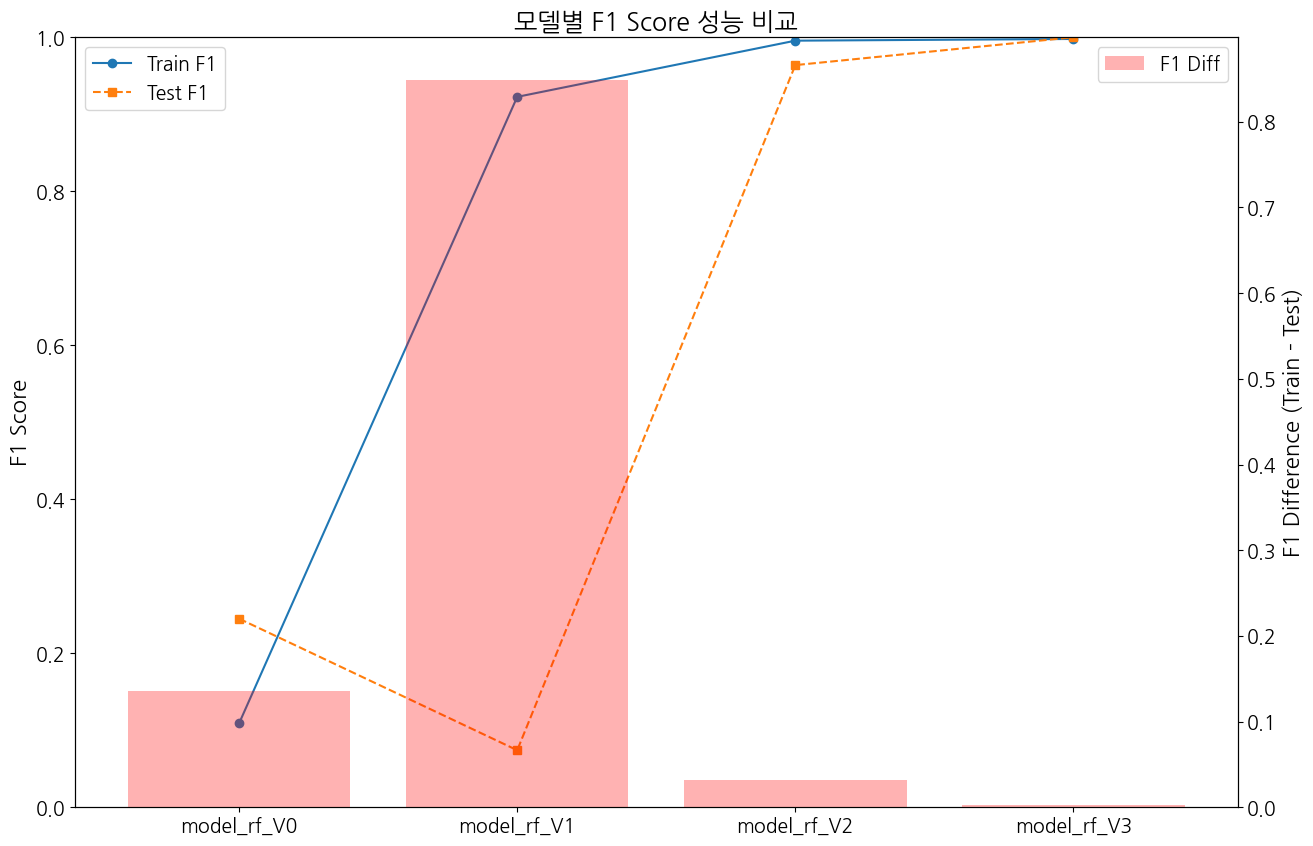

In [78]:
# 저장할 파일 경로 및 파일명 설정
save_path = args.model_comparison_path
file_name = "cluster3_model_comparison"  # 원하는 파일명 지정
full_path = os.path.join(save_path, file_name)

# 저장할 디렉터리가 존재하지 않으면 생성
os.makedirs(save_path, exist_ok=True)

# ✅ model 순서에 따라 오름차순 정렬
df_results = df_results.sort_values(by="model").reset_index(drop=True)

# 그래프 폰트 크기 설정
label_fontsize = 16         # x축, y축 레이블 폰트 크기
legend_fontsize = 14        # 범례 폰트 크기
tick_fontsize = 14          # 눈금 폰트 크기

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(15, 10))

# F1-score 그래프 (순서대로 그래프 그리기)
ax1.plot(df_results["model"], df_results["tr_cv_mean_f1"], marker="o", label="Train F1", linestyle="-")
ax1.plot(df_results["model"], df_results["test_f1"], marker="s", label="Test F1", linestyle="--")
ax1.set_ylabel("F1 Score", fontsize=label_fontsize)
ax1.set_ylim(0.0, 1.0)  # F1-score 범위 (0~1)
ax1.set_title("모델별 F1 Score 성능 비교", fontsize=label_fontsize + 2)
ax1.legend(loc="upper left", fontsize=legend_fontsize)

# 오차(F1 차이) 추가
ax2 = ax1.twinx()
ax2.bar(df_results["model"], df_results["f1_diff"], color="red", alpha=0.3, label="F1 Diff")
ax2.set_ylabel("F1 Difference (Train - Test)", fontsize=label_fontsize)
ax2.set_ylim(0, max(df_results["f1_diff"]) + 0.05)
ax2.legend(loc="upper right", fontsize=legend_fontsize)

# x축 레이블 및 눈금 폰트 크기 설정
ax1.set_xticks(range(len(df_results["model"])))  # 모델 개수만큼 눈금 설정
ax1.set_xticklabels(df_results["model"], fontsize=tick_fontsize)

# y축 눈금 폰트 크기 설정
ax1.tick_params(axis="y", labelsize=tick_fontsize)
ax2.tick_params(axis="y", labelsize=tick_fontsize)

# 그래프를 jpg 파일로 저장 (덮어쓰기 허용)
plt.savefig(full_path, format="jpg", dpi=600, bbox_inches="tight")

# 저장 완료 메시지 출력
print(f"✅ 그래프가 저장되었습니다: {full_path}\n")

plt.show()
